# Predicting house prices in Ames, Iowa

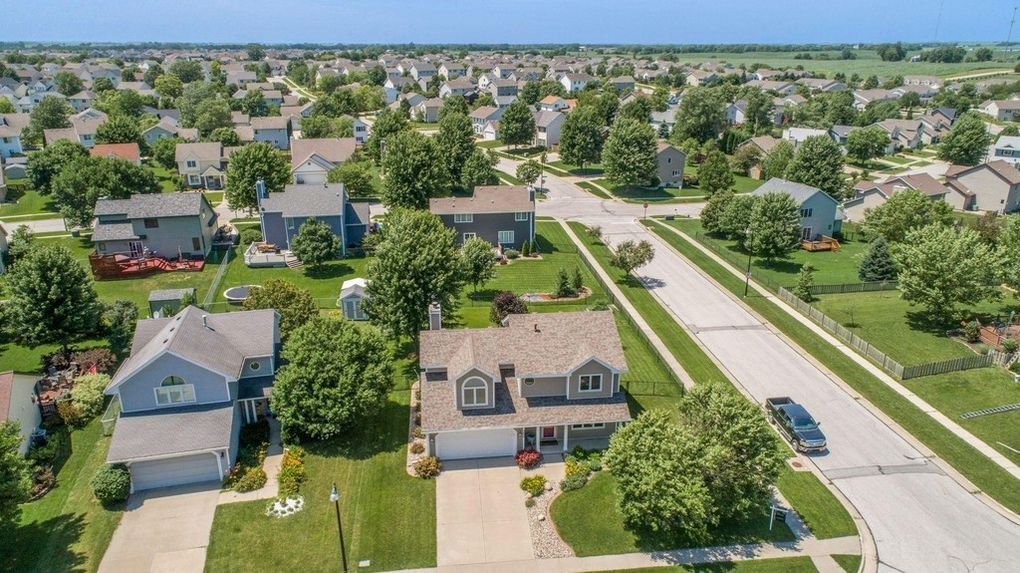

In [205]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

data = pd.read_csv("/Users/tommatthews/PycharmProjects/home-data-for-ml-course/train.csv", index_col='Id')
full_data = data.copy()
target = data['SalePrice']
data.drop(['SalePrice','MiscFeature'], axis=1, inplace=True)

I'm not going to use sklearn's pipeline's as, although it may reduce the amount of code and improve readability, I find it places significant constraints on the exploratory analysis and model evaluation. Let's take a look at the data we have:

In [206]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 78 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

Now build a baseline model for future comparison, to do so throw away features which are non-numerical or have missing values.

In [207]:
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=1)

baseline_cols=[col for col in X_train.columns if (X_train[col].dtype in ('int64', 'float64'))
               and (X_train[col].isna().sum() == 0)]
X_bsln_train = X_train[baseline_cols]
X_bsln_val = X_val[baseline_cols]

baseline_model = LinearRegression()
baseline_model.fit(X_bsln_train, y_train)
y_bsln_pred = baseline_model.predict(X_bsln_val)
bsln_mae = mean_absolute_error(y_bsln_pred, y_val)
print('Baseline mean error: $', np.round(bsln_mae))

Baseline mean error: $ 21955.0


Now I will target encode (convert categorical variables to numerical) the **ordinal** features. For these ordinal columns NA's actually correspond to the absence of the relevent property of the house. For example, an NA for FireplaceQu (fireplace quality) just corresponds the there being no fireplace in the house. Therefore, it is better to assign a fixed value to signify the absense of a house property rather than imputing these values and assigning the mean value to them. 

In [208]:
ordinal_cols = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
                'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'Utilities',
                'LotShape', 'Street', 'LandSlope', 'ExterQual', 'ExterCond', 'HeatingQC', 'CentralAir',
                'KitchenQual', 'Functional', 'PavedDrive']

data_ord = data[ordinal_cols]
data_ord.fillna(0, inplace=True)

ordinal_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5,
               'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3,
               'Grvl': 0, 'Pave': 1,
               'ELO': 0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3,
               'Gtl': 0, 'Mod': 3, 'Sev': 6,
               'N': 0, 'P': 1 ,'Y': 2,
               'Unf': 1, 'RFn': 2, 'Fin': 3,
               'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4,
               'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6,
               'Detchd': 1, 'CarPort': 2, 'BuiltIn': 3, 'Basment': 4, 'Attchd': 5, '2Types': 6,
               'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4,
               'Typ': 0, 'Min1': 1, 'Min2': 2, 'Mod': 3, 'Maj1': 4, 'Maj2': 5, 'Sev': 6, 'Sal': 7
              }

data_ord = data_ord.applymap(lambda s: ordinal_map.get(s) if s in ordinal_map else s)
data[ordinal_cols] = data_ord

In [209]:
# Confirm all ordinal variables have been correctly converted into int or float type variables.
print(data[ordinal_cols].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 24 columns):
Alley           1460 non-null int64
BsmtQual        1460 non-null int64
BsmtCond        1460 non-null int64
BsmtExposure    1460 non-null int64
BsmtFinType1    1460 non-null int64
BsmtFinType2    1460 non-null int64
FireplaceQu     1460 non-null int64
GarageType      1460 non-null int64
GarageFinish    1460 non-null int64
GarageQual      1460 non-null int64
GarageCond      1460 non-null int64
PoolQC          1460 non-null int64
Fence           1460 non-null int64
Utilities       1460 non-null int64
LotShape        1460 non-null int64
Street          1460 non-null int64
LandSlope       1460 non-null int64
ExterQual       1460 non-null int64
ExterCond       1460 non-null int64
HeatingQC       1460 non-null int64
CentralAir      1460 non-null int64
KitchenQual     1460 non-null int64
Functional      1460 non-null int64
PavedDrive      1460 non-null int64
dtypes: int64(24)
memory usag

Next I'll impute the remaining missing values for the numerical and categorical feautes.

In [210]:
numerical_cols = [col for col in data.columns if data[col].dtype in ('int64', 'float64')]
categorical_cols = [col for col in data.columns if data[col].dtype == 'object']

imputer_num = KNNImputer(weights='distance')
imputer_cat = SimpleImputer(strategy='most_frequent')

data_imp_num = pd.DataFrame(imputer_num.fit_transform(data[numerical_cols]),
                                  columns=data[numerical_cols].columns,
                                  index=data.index)

data_imp_cat = pd.DataFrame(imputer_cat.fit_transform(data[categorical_cols]),
                                  columns=data[categorical_cols].columns,
                                  index=data.index)

data = pd.concat([data_imp_num, data_imp_cat], axis=1, ignore_index=False)

print('There are',data.isna().sum().sum(), 'missing values in the data now.')

There are 0 missing values in the data now.


In [211]:
# Get one hot encoding of column
data = pd.get_dummies(data, columns=categorical_cols)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 210 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(60), uint8(150)
memory usage: 909.6 KB
None


## Feature selection

Currently there are 210 features, or approximately 1 feature to every 7 data points. This is an excessively large feature space, therefore I will perform feature selection via the mutual information between the feature and target. I selected the mutual information as it is a more robust feature selection than most others, and doesn't assume a linear relationship between the dependent and independent variable.  By doing so on the full dataset I introduce a further (minor) source of data leakage to the model. If I were preparing this model for deployment I would have performed this feature selection purely on a training set, before evaluating the model performance on a validation set. I would have also retained a test set to evaluate the final model performance before deployment. However, given the minimal data leakage and that the purpose of this project is educational I will proceed as planned.

In [212]:
from sklearn.feature_selection import mutual_info_regression

def feature_selector(data, target, threshold=0.00001):
    drop_col_index = []
    for i in range(data.shape[1]):
        mi = mutual_info_regression(np.array(data.iloc[:,i]).reshape(-1, 1), target)
        if mi < threshold:
            drop_col_index.append(i)
    return drop_col_index

# Take only the most important features to investigate multicolinearity
top_features_data = data.copy()
top_cols_to_drop = feature_selector(top_features_data, target, threshold=0.35)
top_features_data.drop(top_features_data.columns[top_cols_to_drop], axis=1, inplace=True)

# Perform feature selection on the primary data
cols_to_drop = feature_selector(data, target)
data.drop(data.columns[cols_to_drop], axis=1, inplace=True)

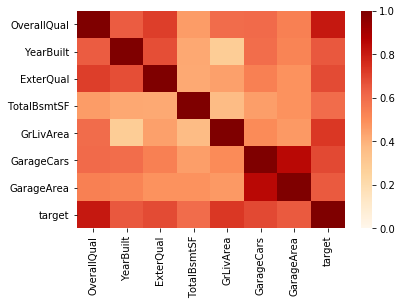

In [213]:
top_features_data['target'] = target
sns.heatmap(top_features_data.corr(method='spearman'), cmap='OrRd', vmin=0, vmax=1);

# Fix bug in seaborn
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t) 
plt.show()

We can see that GarageArea and GarageCars exhibit strong colinearity.

## Model selection and evaluation

In [214]:
models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('SVM (RBF kernel)', SVR()))
models.append(('K-nearest neighbours', KNeighborsRegressor()))
models.append(('Random Forests', RandomForestRegressor()))
models.append(('X Gradient boosting', XGBRegressor(objective ='reg:squarederror')))

results = []
names = []

for name, model in models:
    cv_scores = -1 * cross_val_score(model, data, target, cv=5, scoring='neg_mean_absolute_error')
    results.append(cv_scores)
    names.append(name)
    msg = '%s: $%f +/- (%f)' % (name, round(cv_scores.mean(),1), round(cv_scores.std(),1))
    print(msg)

Linear Regression: $19565.800000 +/- (1492.400000)
SVM (RBF kernel): $55545.800000 +/- (3358.600000)
K-nearest neighbours: $29765.000000 +/- (2307.400000)
Random Forests: $17604.500000 +/- (815.500000)
X Gradient boosting: $16256.600000 +/- (826.100000)


The gradient boosting regression algorithm appears to best the best performer, so I will proceed with this model and search for the optimal hyperparameters.

In [215]:
best_model = XGBRegressor(objective ='reg:squarederror')

In [216]:
def optimise_hyperparameters(parameters, data, target):
    search_model = GridSearchCV(estimator=best_model, param_grid=parameters, n_jobs=-1,
                             scoring='neg_mean_absolute_error')
    search_model.fit(data, target)
    print('Best mean error: $', -1*search_model.best_score_)
    print('Optimal hyperparameters: \n', search_model.best_params_)



optimise_hyperparameters1 = False
if optimise_hyperparameters1:
    
    param_grid1 = { "n_estimators": [200, 400, 600],
                   "learning_rate" : [0.02, 0.04, 0.06],
                   "colsample_bytree" : [0.7, 0.8],
                   "subsample": [0.6, 0.8],
                   "gamma" : [0, 0.05, 0.1]}
    
    optimise_hyperparameters(param_grid1, data, target)

In [217]:
optimise_hyperparameters2 = False
if optimise_hyperparameters2:
    param_grid2 = { "n_estimators": [600, 700, 800],
                   "learning_rate" : [0.05, 0.06],
                   "colsample_bytree" : [0.8],
                   "subsample": [0.8, 0.9]}
    
    optimise_hyperparameters(param_grid2, data, target)

In [218]:
best_model = XGBRegressor(random_state=3,
                          objective ='reg:squarederror',
                          n_estimators=800,
                          learning_rate=0.06,
                          colsample_bytree=0.8,
                          subsample=0.9)

scores = cross_val_score(best_model, data, target, cv=5, scoring=make_scorer(mean_absolute_error))
print('Best model mean error: $', int(np.mean(scores)))

Best model mean error: $ 15026


## Model evaluation

In [219]:
import shap
import eli5
from eli5.sklearn import PermutationImportance

In [220]:
train_X, val_X, train_y, val_y = train_test_split(data, target, test_size=0.2, random_state=1)
best_model.fit(train_X, train_y)

perm = PermutationImportance(best_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.1231 ± 0.0216,GrLivArea
0.1213 ± 0.0282,OverallQual
0.0325 ± 0.0008,2ndFlrSF
0.0255 ± 0.0012,TotalBsmtSF
0.0238 ± 0.0035,BsmtFinSF1
0.0232 ± 0.0042,GarageCars
0.0094 ± 0.0057,LotArea
0.0078 ± 0.0030,OverallCond
0.0074 ± 0.0067,BsmtExposure
0.0066 ± 0.0026,ExterQual


Note that these weights quantify the feature importance to the model. They are found by randomly permuting the observations of each feature and seeing the resulting degradation of the model, the worse the impact of shuffling the data on the model predictions, the more important the feature.

Next I will use the SHAP library to investigate the Shapley values of the model, a game theoretic approach to explaining the output of the model.

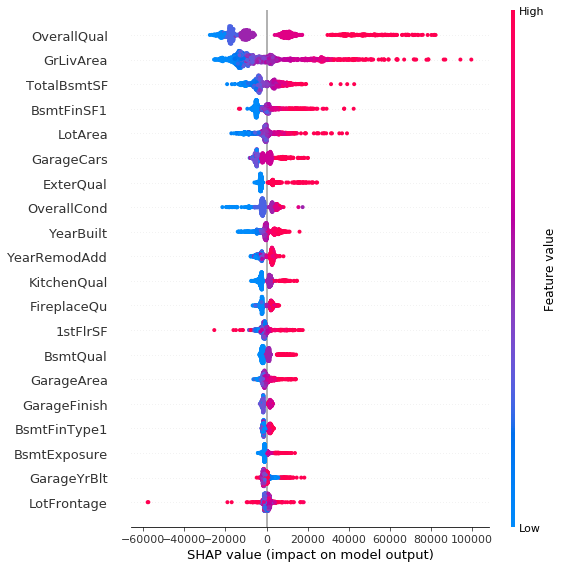

In [221]:
best_model.fit(train_X, train_y)
explainer = shap.TreeExplainer(best_model)
shap_values1 = explainer.shap_values(train_X)
shap.summary_plot(shap_values1, train_X)

In this plot the higher the horizontal spread of values, the greater the impact on the model. The way the features interact with the model is demonstrated by the colour of the data points. For example, if the colour monotonically changes from blue (low value) to red (high value) as you move from left to right, there is a positive correlation between that feature and the house price.

The plots below show the partial dependence of a feature, that is how a given feature impacts the model output, along with the change with a further confounding feature that exhibits the greatest interaction with that feature.

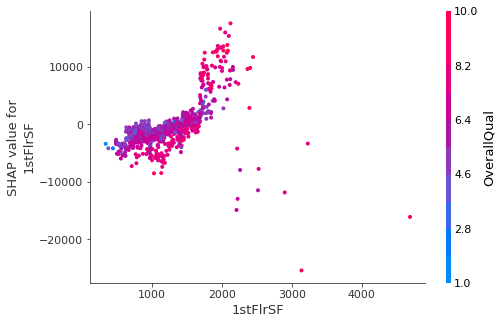

In [222]:
shap.dependence_plot('1stFlrSF', shap_values1, train_X)

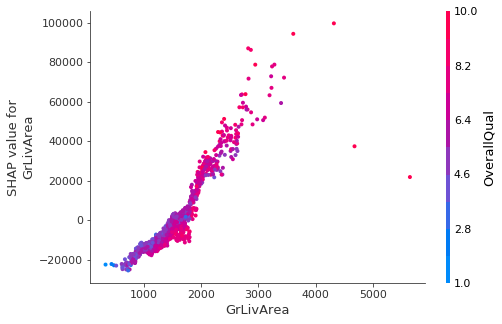

In [223]:
shap.dependence_plot('GrLivArea', shap_values1, train_X)

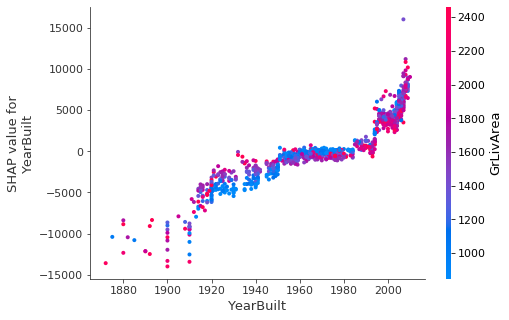

In [224]:
shap.dependence_plot('YearBuilt', shap_values1, train_X)

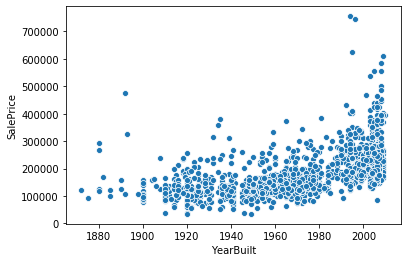

In [225]:
sns.scatterplot(data['YearBuilt'], target);

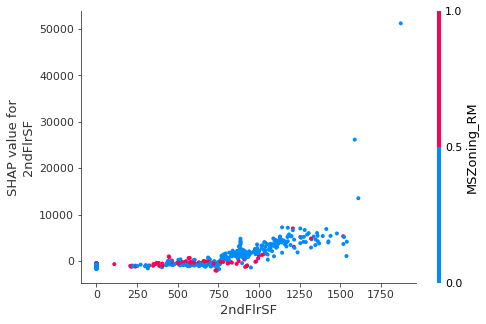

In [226]:
shap.dependence_plot('2ndFlrSF', shap_values1, train_X)

In [227]:
# Check the individual SHAP values
shap.initjs()

def shap_plot(j):
    explainer_model = shap.TreeExplainer(best_model)
    shap_values_model = explainer_model.shap_values(val_X)
    p = shap.force_plot(explainer_model.expected_value, shap_values_model[j], val_X.iloc[[j]])
    return p

Now to look at individual house price predictions let's first find the mean and standard deviation of the house prices to get a sense the scale of the value.

In [228]:
print('Mean house price: $', int(target.mean()), '+/-', int(target.std()))

Mean house price: $ 180921 +/- 79442


In [229]:
print('Actual sale price: $', val_y.iloc[3])
shap_plot(3)

Actual sale price: $ 84500


The model has predicted this house to sell for less the one standard deviation below the mean. The primary reasons for this low prediction is that the house a small with a low quality finish and no garage.

In [230]:
print('Actual sale price: $', val_y.iloc[130])
shap_plot(130)

Actual sale price: $ 280000


The model has predicted this house to sell for over one standard deviation higher than the mean. We can see the primary factors driving this price is the fact the house is brand new, having a large and high quality ground floor living area along with a large garage capable of storing 3 cars.